# Prueba de biblioteca Lifetimes

Importando las dependencias:

In [1]:
import pandas as pd
from lifetimes.datasets import load_cdnow_summary
from lifetimes.datasets import load_transaction_data
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data

## Cargando el dataset de prueba de la biblioteca Lifetimes

Este dataset está basado en información de la empresa CDNow. Inicialmente ya se realizó el análisis RFM y la data contiene los siguientes atributos:

- **Recency**: ¿Hace cuánto tiempo compró un cliente?
- **Frecuency**: ¿Con qué frecuencia/consistencia compra un cliente?
- **T**: Unidad de tiempo, en este caso representa una semana.

In [2]:
data = load_cdnow_summary(index_col=[0])
print(data)

      frequency  recency      T
ID                             
1             2    30.43  38.86
2             1     1.71  38.86
3             0     0.00  38.86
4             0     0.00  38.86
5             0     0.00  38.86
...         ...      ...    ...
2353          0     0.00  27.00
2354          5    24.29  27.00
2355          0     0.00  27.00
2356          4    26.57  27.00
2357          0     0.00  27.00

[2357 rows x 3 columns]


Creando y ajustando el modelo de Pareto / NBD con el dataset:

In [3]:
model = ParetoNBDFitter(penalizer_coef=0.0)
model.fit(data['frequency'], data['recency'], data['T'])
print(model)


<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 10.58, beta: 11.67, r: 0.55, s: 0.61>


## Matriz de Frecuencia/Recencia

Si un cliente ha comprado todos los días durante tres semanas seguidas, y no ha vuelto a comprar en meses. ¿Cuáles son las posibilidades de que este cliente todavía esté "vivo"? Muy pequeña. 

Por otro lado, un cliente que históricamente compra una vez al trimestre y compró el último trimestre, probablemente aún esté vivo. 

Podemos visualizar esta relación utilizando la matriz Frecuencia/Recency, que calcula el número esperado de transacciones que un cliente artificial realizará en el próximo período de tiempo, dada su Recency (edad en la última compra) y Frecuency (el número de transacciones repetidas).

<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

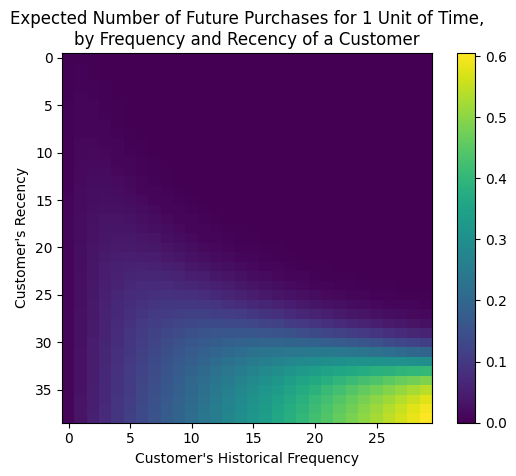

In [4]:
plot_frequency_recency_matrix(model)

Podemos ver que si un cliente ha comprado 25 veces, y su última compra fue cuando tenía 35 semanas (dado que la persona tiene 35 semanas), entonces es su mejor cliente (abajo a la derecha). Tus clientes más fríos son los que están en la esquina superior derecha: compraron mucho rápido y no los hemos visto en semanas.

También está esa hermosa “cola” alrededor (5,25). Eso representa al cliente que compra con poca frecuencia, pero lo hemos visto recientemente, por lo que podría volver a comprar; no estamos seguros de si está muerto o solo entre compras.

Otra matriz interesante para observar es la probabilidad de seguir vivo:

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

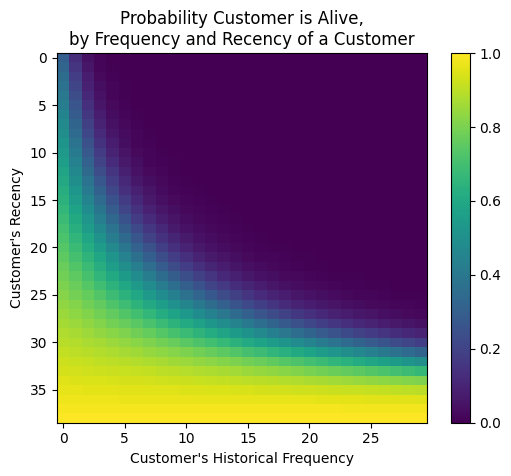

In [5]:
plot_probability_alive_matrix(model)


In [6]:
t = 1
data['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(
    t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.392775
841,19,34.00,34.14,0.433571
1981,17,28.43,28.86,0.438667
157,29,37.71,38.00,0.602357
1516,26,30.86,31.00,0.632844


<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

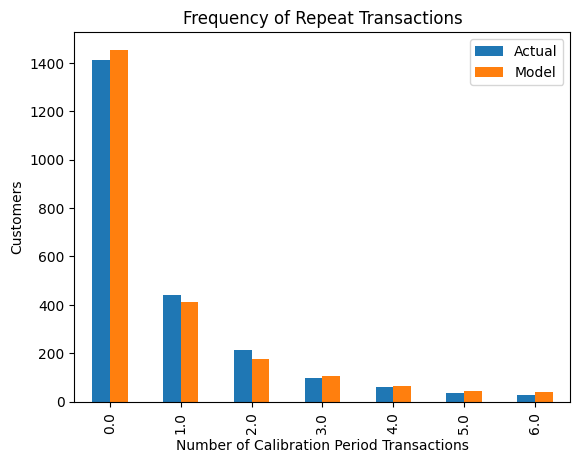

In [7]:
plot_period_transactions(model)


# Trabajando con tabla de pedidos

In [8]:
transaction_data = load_transaction_data()
transaction_data['date'] = pd.to_datetime(
    transaction_data['date'], format='%Y-%m-%d %H:%M')

print(transaction_data.head())


        date  id
0 2014-03-08   0
1 2014-05-21   1
2 2014-03-14   2
3 2014-04-09   2
4 2014-05-21   2


In [9]:
summary = summary_data_from_transaction_data(
    transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())


    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [10]:
model.fit(summary['frequency'], summary['recency'], summary['T'])
print(model)

<lifetimes.ParetoNBDFitter: fitted with 5000 subjects, alpha: 13.54, beta: 19.64, r: 0.82, s: 1.18>


In [11]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                                   calibration_period_end='2014-09-01',
                                                   observation_period_end='2014-12-31')
print(summary_cal_holdout.head())


    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0             121.0
1             0.0          0.0  103.0                0.0             121.0
2             6.0        142.0  171.0                0.0             121.0
3             0.0          0.0   26.0                0.0             121.0
4             2.0          9.0   62.0                0.0             121.0


<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

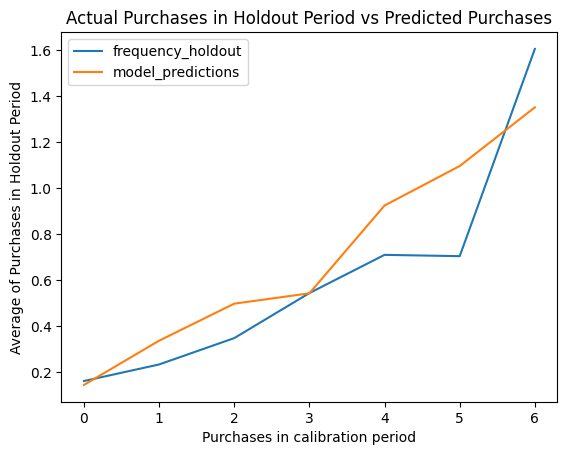

In [12]:
model.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(model, summary_cal_holdout)


In [13]:
t = 10  # predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
model.predict(t, individual['frequency'],
              individual['recency'], individual['T'])
# 0.0576511


0.06004934615837705

<AxesSubplot: title={'center': 'History of P_alive'}, ylabel='P_alive'>

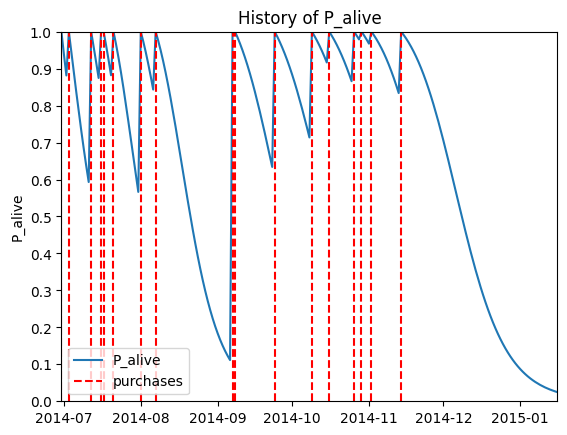

In [14]:
id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(model, days_since_birth, sp_trans, 'date')
